# 個体間関係

## おまじないパート

In [1]:
import sys
from pathlib import Path

# 現在のノートブックのパスを取得
notebook_dir = Path().resolve() 

# プロジェクトルートディレクトリ（notebooksディレクトリの親ディレクトリ）を取得
# プロジェクトルートは2階層上です
project_root = notebook_dir.parent.parent

# プロジェクトルートをPythonの検索パスに追加
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

In [2]:
from groom import save_to_parquet, load_from_parquet, \
        save_model, load_model

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

## データ読みこみ

In [4]:
df_matrix = pd.read_csv(
    "../../data/00_raw_data/Kojima_gr_combination.csv", 
    index_col=0
)

df_attr = pd.read_csv(
    "../../data/00_raw_data/monkey_data.csv"
)

In [5]:
print(df_matrix.head())

         Kannna  Tane  Takana  Hamayu  Yotsuba  Komatsu  Botan  Peach  Hiba  \
Kannna      NaN   NaN     NaN     NaN      2.0      NaN    NaN    NaN   NaN   
Tane        NaN   NaN     NaN     NaN      NaN      5.0    NaN    NaN   NaN   
Takana      NaN   NaN     NaN     NaN      NaN      NaN    NaN    NaN   NaN   
Hamayu      NaN   NaN     NaN     NaN      2.0      NaN    1.0    NaN   NaN   
Yotsuba     4.0   NaN     NaN     1.0      NaN      NaN    NaN    1.0   NaN   

         Tabu  ...  Yone  Yuna  Beni  Tsukasa  Teriba  Hinoki  Gure  Kobu  \
Kannna    NaN  ...   NaN   6.0   NaN      NaN     NaN     NaN   NaN   2.0   
Tane      NaN  ...   NaN   NaN   NaN      NaN     NaN     NaN   NaN   NaN   
Takana    1.0  ...   NaN   NaN   NaN      NaN     NaN     NaN   NaN   NaN   
Hamayu    NaN  ...   1.0   NaN   NaN      1.0     NaN     NaN   NaN   1.0   
Yotsuba   NaN  ...   1.0   NaN   NaN      NaN     NaN     NaN   NaN   NaN   

         Nishin  Meji  
Kannna      NaN   NaN  
Tane        Na

In [6]:
print(df_attr.head())

   id    name sex  age child child2 sibling_1 sibling_2
0   1  Kannna   f   20    10     na        na        na
1   2    Gure   m   19    na     na        na        na
2   3    Kizu   f   18    16     27        na        na
3   4   Mikan   f   17    na     na        na        na
4   5    Kobu   m   17    na     na        20        na


### グルーミングに基づく関係グラフの構築

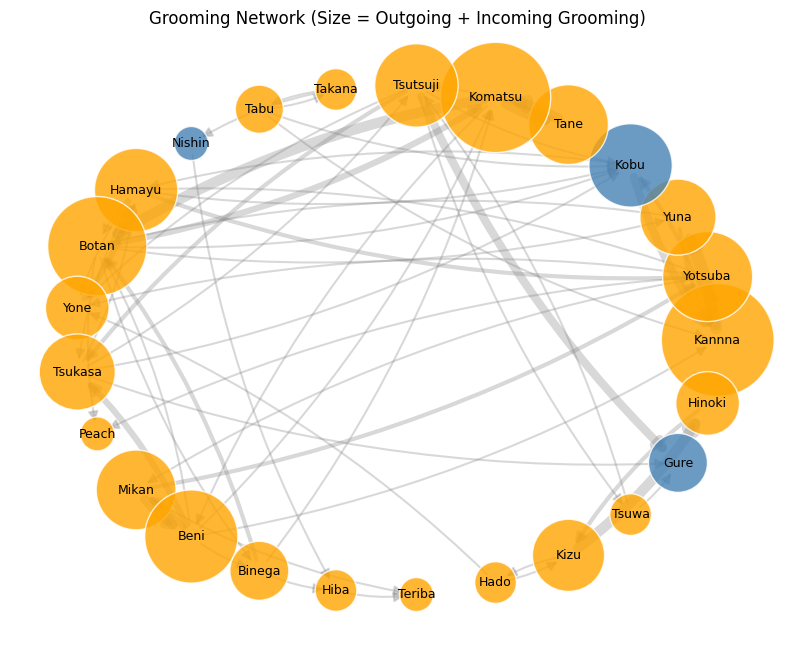

In [7]:
# グラフ構築
G = nx.DiGraph()
for _actor in df_matrix.index:
    for _receiver in df_matrix.columns:
        _weight = df_matrix.loc[_actor, _receiver]
        if not plt.np.isnan(_weight) and _weight > 0:
            G.add_edge(_actor, _receiver, weight=float(_weight))

# 性別色分け
node_colors = []
for _node in G.nodes():
    _row = df_attr[df_attr['name'] == _node]
    if not _row.empty:
        _sex = _row.iloc[0]['sex']
        node_colors.append('orange' if _sex == 'f' else 'steelblue' if _sex == 'm' else 'gray')
    else:
        node_colors.append('gray')

# 描画
fig, ax = plt.subplots(figsize=(10, 8))
pos = nx.circular_layout(G)

node_strength = dict(G.degree(weight='weight'))
node_sizes = [node_strength[n] * 300 for n in G.nodes()]
edge_widths = [G[u][v]['weight'] * 1.5 for u, v in G.edges()]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8, edgecolors='white', ax=ax)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', alpha=0.3, arrowsize=15, connectionstyle='arc3,rad=0.1', ax=ax)
nx.draw_networkx_labels(G, pos, font_size=9)

ax.set_title("Grooming Network (Size = Outgoing + Incoming Grooming)")
ax.axis('off')

plt.show()

### 中心性の計算

中心性 := groomingを受けた数 + やった数

In [8]:
import pandas as pd

# 1. 重み付き中心性（Strength）を計算
# G.degree(weight='weight') は (ノード名, 重み合計) のタプルを返すので辞書に変換します
weighted_degree_dict = dict(G.degree(weight='weight'))

# 2. DataFrame の作成
df_centrality = pd.DataFrame(list(weighted_degree_dict.items()), columns=['name', 'centrality'])

# 3. 値が大きい順（中心性が高い順）に並び替え
df_centrality = df_centrality.sort_values('centrality', ascending=False).reset_index(drop=True)

# 結果の表示
print(df_centrality.head(10))

       name  centrality
0    Kannna        22.0
1   Komatsu        21.0
2     Botan        17.0
3      Beni        15.0
4   Yotsuba        14.0
5  Tsutsuji        12.0
6    Hamayu        12.0
7      Kobu        12.0
8      Tane        11.0
9     Mikan        11.0


centralityの保存

In [15]:
save_to_parquet(
    df_centrality, 
    "../../data/01_relationship_data/centrality_df.parquet"
)

--- 保存完了 ---
'../../data/01_relationship_data/centrality_df.parquet' として保存されました。ファイルサイズ: 2.39 KB


## 攻撃関係

### 攻撃dataの読み込み

In [9]:
df_aggresion = pd.read_csv(
    "../../data/00_raw_data/Kojima_aggression.csv", 
    index_col=0
)

In [10]:
print(df_aggresion.head())

         Kannna  Tane  Takana  Hamayu  Yotsuba  Komatsu  Botan  Peach  Hiba  \
Kannna      NaN   NaN     NaN     NaN      NaN      NaN    NaN    NaN   NaN   
Tane        NaN   NaN     NaN     NaN      NaN      NaN    NaN    NaN   1.0   
Takana      NaN   1.0     NaN     NaN      NaN      2.0    NaN    NaN   2.0   
Hamayu      NaN   NaN     NaN     NaN      1.0      NaN    NaN    1.0   NaN   
Yotsuba     NaN   NaN     NaN     NaN      NaN      NaN    NaN    NaN   NaN   

         Tabu  ...  Tsutsuji  Mikan  Kizu  Tsuwa  Yone  Yuna  Beni  Tsukasa  \
Kannna    NaN  ...       NaN    NaN   NaN    NaN   NaN   NaN   NaN      NaN   
Tane      NaN  ...       NaN    1.0   NaN    1.0   1.0   NaN   NaN      NaN   
Takana    NaN  ...       1.0    NaN   2.0    2.0   NaN   NaN   NaN      2.0   
Hamayu    NaN  ...       NaN    NaN   NaN    NaN   NaN   NaN   1.0      NaN   
Yotsuba   NaN  ...       NaN    NaN   NaN    NaN   NaN   NaN   NaN      NaN   

         Teriba  Hinoki  
Kannna      NaN     NaN 

### 攻撃関係に基づくグラフの構築
（ノードサイズは攻撃を仕掛けた回数（Out-degree）を反映）

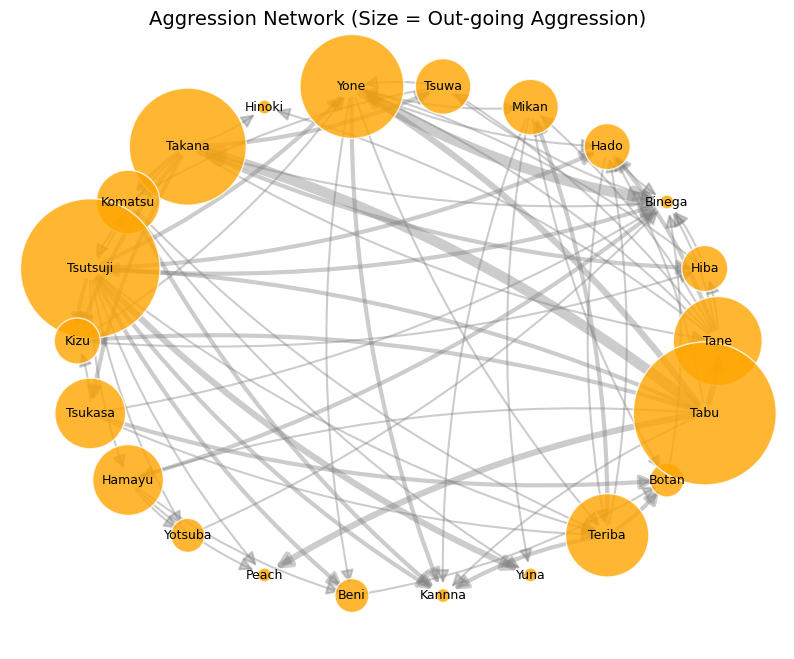

In [11]:
# 1. 攻撃グラフの構築
G_agg = nx.DiGraph()
for _actor in df_aggresion.index:
    for _receiver in df_aggresion.columns:
        _weight = df_aggresion.loc[_actor, _receiver]
        # 欠損値でなく、1回以上の攻撃がある場合
        if not plt.np.isnan(_weight) and _weight > 0:
            G_agg.add_edge(_actor, _receiver, weight=float(_weight))

# 2. 性別に基づく色分け（既存のロジックを流用）
node_colors_agg = []
for _node in G_agg.nodes():
    _row = df_attr[df_attr['name'] == _node]
    if not _row.empty:
        _sex = _row.iloc[0]['sex']
        node_colors_agg.append('orange' if _sex == 'f' else 'steelblue' if _sex == 'm' else 'gray')
    else:
        node_colors_agg.append('gray')

# 3. 描画の設定
fig_agg, ax_agg = plt.subplots(figsize=(10, 8))
pos_agg = nx.circular_layout(G_agg)

# ノードサイズ：攻撃を仕掛けた数 (Out-degree strength)
# out_degree(weight='weight') を使用
node_out_strength = dict(G_agg.out_degree(weight='weight'))
# サイズが0だと見えないため、最小値（例: 100）を足すかスケーリングを調整します
node_sizes_agg = [(node_out_strength[n] * 500) + 100 for n in G_agg.nodes()]

# エッジの太さ（攻撃の激しさ）
agg_weights = [G_agg[u][v]['weight'] * 1.5 for u, v in G_agg.edges()]

# 4. 描画実行
nx.draw_networkx_nodes(G_agg, pos_agg, node_color=node_colors_agg, 
                       node_size=node_sizes_agg, alpha=0.8, edgecolors='white', ax=ax_agg)

# エッジの色をgroomingと同様に灰色（gray）に変更
nx.draw_networkx_edges(G_agg, pos_agg, width=agg_weights, edge_color='gray', 
                       alpha=0.4, arrowsize=20, connectionstyle='arc3,rad=0.1', ax=ax_agg)

nx.draw_networkx_labels(G_agg, pos_agg, font_size=9)

ax_agg.set_title("Aggression Network (Size = Out-going Aggression)", fontsize=14)
ax_agg.axis('off')

plt.show()

## David's Score による順位分析

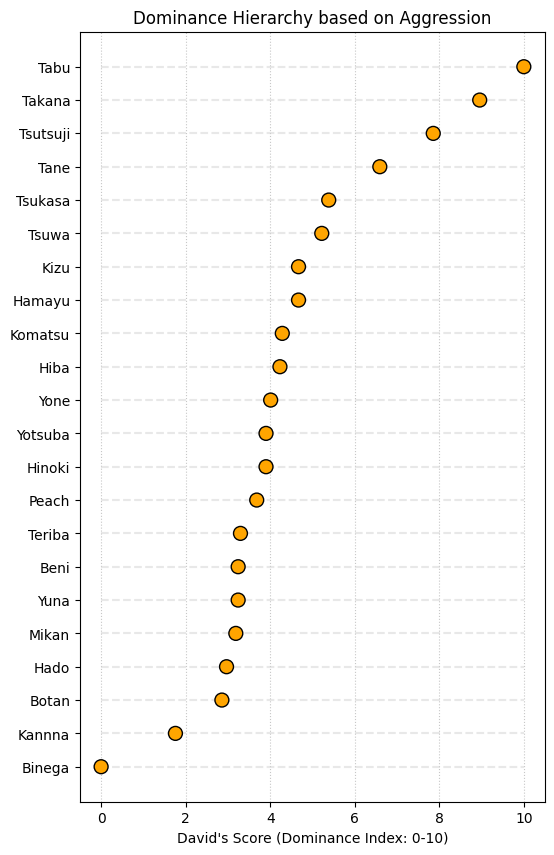

In [12]:
# 1. David's Score の計算準備
# 行列を numpy 形式に変換 (NaNは0に置換)
mat = df_aggresion.fillna(0).values
n = mat.shape[0]

# 個体間の勝率行列 P_ij (iがjに勝った回数 / (iがjに勝った + jがiに勝った))
P = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            total = mat[i, j] + mat[j, i]
            if total > 0:
                P[i, j] = mat[i, j] / total

# 2. 各指標の計算
w1 = np.sum(P, axis=1)
w2 = np.dot(P, w1)
l1 = np.sum(P.T, axis=1)
l2 = np.dot(P.T, l1)

ds = w1 + w2 - l1 - l2

# 0 ~ 10 の範囲に正規化（ご要望のスケール）
ds_min, ds_max = np.min(ds), np.max(ds)
ds_scaled = 10 * (ds - ds_min) / (ds_max - ds_min)

# 3. 結果をDataFrameにまとめる
df_rank = pd.DataFrame({
    'name': df_aggresion.index,
    'davids_score': ds_scaled
}).sort_values('davids_score', ascending=True) # グラフ用に昇順

# 性別情報の結合
df_rank = pd.merge(df_rank, df_attr[['name', 'sex']], on='name', how='left')

# 4. グラフ作成 (monkey_rank.png 風)
fig_rank, ax_rank = plt.subplots(figsize=(6, 10))

colors = df_rank['sex'].map({'f': 'orange', 'm': 'steelblue'}).fillna('gray')

# ドットプロットの描画
ax_rank.hlines(y=df_rank['name'], xmin=0, xmax=10, color='lightgray', linestyle='--', alpha=0.5)
ax_rank.scatter(df_rank['davids_score'], df_rank['name'], c=colors, s=100, edgecolors='black', zorder=3)

ax_rank.set_xlabel("David's Score (Dominance Index: 0-10)")
ax_rank.set_title("Dominance Hierarchy based on Aggression")
ax_rank.set_xlim(-0.5, 10.5)
ax_rank.grid(axis='x', linestyle=':', alpha=0.7)

plt.show()

### 順位の割り振り

In [13]:
# 1. 順位を計算 (スコアが高い順に 1, 2, 3...)
# method='min' は同点の場合に若い方の順位を割り振る設定です
df_rank['rank'] = df_rank['davids_score'].rank(ascending=False, method='min').astype(int)

# 2. 順位順（1位〜）に並べ替える
df_rank = df_rank.sort_values('rank')

# 3. 名前と順位のペアを抽出した新しいDataFrameを作成
df_hierarchy = df_rank[['name', 'rank']].copy()

# 結果の表示
print(df_hierarchy)

        name  rank
21      Tabu     1
20    Takana     2
19  Tsutsuji     3
18      Tane     4
17   Tsukasa     5
16     Tsuwa     6
15      Kizu     7
14    Hamayu     7
13   Komatsu     9
12      Hiba    10
11      Yone    11
9     Hinoki    12
10   Yotsuba    12
8      Peach    14
7     Teriba    15
5       Yuna    16
6       Beni    16
4      Mikan    18
3       Hado    19
2      Botan    20
1     Kannna    21
0     Binega    22


順位の保存

In [14]:
save_to_parquet(
    df_hierarchy,
    "../../data/01_relationship_data/rank_df.parquet"
)

--- 保存完了 ---
'../../data/01_relationship_data/rank_df.parquet' として保存されました。ファイルサイズ: 2.92 KB
